In [7]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import sys, torch, os, json, copy, csv
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
sys.path.append('/content/drive/MyDrive/Colab Notebooks/practice/download/model')
from quant import QuantizableMobileNetV4
import torch.optim as optim
from tqdm import tqdm
from torch import nn, Tensor
from mobilenet import mobilenetv4_conv_medium
import torch.nn.utils.prune as prune
import pandas as pd
import matplotlib.pyplot as plt

# **데이터셋 정의**

In [9]:
# 입력 및 라벨 디렉토리 설정
input_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/seg_images'
label_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/labels'

def load_dataset(input_dir, label_dir):
    intput_files = os.listdir(input_dir)
    label_files = os.listdir(label_dir)

    dataset = []
    for input_file in intput_files:
        label_file = input_file.replace('.png', '.json')
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label_data = json.load(f)
            browning = label_data['annotations']['polygon'][0]['browning']

        dataset.append({
            'image_path': os.path.join(input_dir, input_file),
            'label': f'{browning}'
        })
    return dataset

dataset = load_dataset(input_dir, label_dir)
labels = [data['label'] for data in dataset]

# 데이터 분할
train_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, temp_idx in train_split.split(dataset, labels):
    train_set = [dataset[i] for i in train_idx]
    temp_set = [dataset[i] for i in temp_idx]
val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)
labels_temp = [labels[i] for i in temp_idx]
for val_idx, test_idx in val_test_split.split(temp_set, labels_temp):
    val_set = [temp_set[i] for i in val_idx]
    test_set = [temp_set[i] for i in test_idx]

# 클래스별 개수 확인
train_label_count = Counter([data['label'] for data in train_set])
val_label_count   = Counter([data['label'] for data in val_set])
test_label_count  = Counter([data['label'] for data in test_set])

print("Train set class counts:", train_label_count)
print("Validation set class counts:", val_label_count)
print("Test set class counts:", test_label_count)

Train set class counts: Counter({'True': 35, 'False': 35})
Validation set class counts: Counter({'False': 5, 'True': 5})
Test set class counts: Counter({'False': 10, 'True': 10})


In [10]:
# 전처리 설정
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=MEAN, std=STD)
transform = transforms.Compose([
    transforms.ToTensor()])

def preprocess_image(image):
    non_zero_mask = (image > 0).any(axis=-1)
    non_zero_rows = np.any(non_zero_mask, axis=1)
    non_zero_cols = np.any(non_zero_mask, axis=0)
    min_row, max_row = np.where(non_zero_rows)[0][[0, -1]]
    min_col, max_col = np.where(non_zero_cols)[0][[0, -1]]
    image = image[min_row:max_row+1, min_col:max_col+1]
    image = Image.fromarray(image)
    image = image.resize((224, 224))
    return image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, num_classes=2):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        image = preprocess_image(image)
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloader(dataset, transform, batch_size, shuffle, num_workers):
    image_paths = [item['image_path'] for item in dataset]
    labels = [0 if item['label'] == 'True' else 1 for item in dataset]
    custom_dataset = CustomDataset(image_paths, labels, transform=transform)
    return DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# 데이터로더 생성
train_loader = create_dataloader(train_set, transform, batch_size=24, shuffle=True, num_workers=2)
val_loader = create_dataloader(val_set, transform, batch_size=24, shuffle=False, num_workers=2)
test_loader = create_dataloader(test_set, transform, batch_size=24, shuffle=False, num_workers=2)

# **FP32**

In [11]:
# 모델 크기 출력 함수
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

# CPU 디바이스 설정 및 손실 함수 정의
cpu_device = torch.device("cpu")
CE = nn.CrossEntropyLoss()

# 사전 학습된 모델 로드 및 평가
pretrained_path = '/content/drive/MyDrive/Colab Notebooks/practice/download/model/pretrain.pth'
FP32 = mobilenetv4_conv_medium(num_classes=2)
FP32.load_state_dict(torch.load(pretrained_path, map_location=cpu_device))
FP32.to(cpu_device)
FP32.eval()

total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(cpu_device)
        labels = labels.to(cpu_device)

        outputs = FP32(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

# 평가지표 출력
print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

# 모델 크기 출력
print_model_size(FP32)

<ipython-input-11-7e3ce75e5e98>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  FP32.load_state_dict(torch.load(pretrained_path, map_location=cpu_device))


Test Metrics: Loss=0.0626, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
34.15 MB


# **비구조적 가지치기 (Unstructured pruning)**

In [12]:
# 양자화 가능한 모델 설정
model = QuantizableMobileNetV4(num_classes=2)
model.to(cpu_device)
model.load_state_dict(torch.load(pretrained_path, map_location=cpu_device))
model.eval()
model.fuse_model()
model.train()

model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
torch.ao.quantization.prepare_qat(model, inplace=True)

<ipython-input-12-4468c621b91a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path, map_location=cpu_device))
/usr/local/lib/p

QuantizableMobileNetV4(
  (features): Sequential(
    (0): QuantizableConvBN(
      (block): Sequential(
        (0): ConvBnReLU2d(
          3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
            (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
          )
          (activation_post_process): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qschem

In [13]:
# 모델 복사 및 가지치기
ori_model = copy.deepcopy(model)
prunned_model = copy.deepcopy(ori_model)
for name, module in prunned_model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        prune.l1_unstructured(module, name='weight', amount=0.3)

# 희소성 계산 함수
def count_sparsity(model):
    total_params = 0
    total_zero = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weight_sparsity = float(torch.sum(module.weight == 0)) / module.weight.numel()
            print(f"{name}: weight sparsity={weight_sparsity*100:.2f}%")
            total_zero += torch.sum(module.weight == 0).item()
            total_params += module.weight.numel()
    print(f"Total zeros: {total_zero} out of {total_params} ({(total_zero / total_params) * 100:.2f}%)")

# 희소성 출력
count_sparsity(prunned_model)

features.0.block.0: weight sparsity=29.98%
features.1.block.0: weight sparsity=30.00%
features.2.block.0: weight sparsity=30.00%
features.3.start_dw_conv: weight sparsity=30.09%
features.3.expand_conv: weight sparsity=30.00%
features.3.middle_dw_conv: weight sparsity=30.00%
features.3.proj_conv: weight sparsity=30.00%
features.4.start_dw_conv: weight sparsity=30.00%
features.4.expand_conv: weight sparsity=30.00%
features.4.middle_dw_conv: weight sparsity=30.00%
features.4.proj_conv: weight sparsity=30.00%
features.5.start_dw_conv: weight sparsity=30.00%
features.5.expand_conv: weight sparsity=30.00%
features.5.middle_dw_conv: weight sparsity=30.00%
features.5.proj_conv: weight sparsity=30.00%
features.6.start_dw_conv: weight sparsity=30.00%
features.6.expand_conv: weight sparsity=30.00%
features.6.middle_dw_conv: weight sparsity=30.00%
features.6.proj_conv: weight sparsity=30.00%
features.7.start_dw_conv: weight sparsity=30.00%
features.7.expand_conv: weight sparsity=30.00%
features.7.

In [14]:
# 가지치기 마스크 제거
for name, module in prunned_model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        if hasattr(module, 'weight_mask'):
            prune.remove(module, 'weight')
prunned_model.eval()

# 가지치기된 모델 평가
total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(cpu_device)
        labels = labels.to(cpu_device)

        outputs = prunned_model(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

# 가지치기된 모델 크기 출력
print_model_size(prunned_model)

Test Metrics: Loss=0.6503, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
35.13 MB


# **양자화 인지 훈련 (Quantization Aware Training)**

In [25]:
# 로그 경로
log_dir = '/content/drive/MyDrive/Colab Notebooks/practice/log'
log_csv_path = os.path.join(log_dir, 'QAT_log.csv')

# 하이퍼파라미터 설정
num_epochs = 50
patience = 5
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# QAT 모델 복사
QAT_model = copy.deepcopy(ori_model)
for params in QAT_model.parameters():
    params.requires_grad = True

# 가지치기 적용
for name, module in QAT_model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        prune.l1_unstructured(module, name='weight', amount=0.3)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
QAT_model.to(device)

# 옵티마이저 설정
optimizer = optim.Adam(QAT_model.parameters(), lr=0.001)

cuda


In [26]:
# 모델 학습
def train_val_epoch(model, dataloader, phase, optimizer=None):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc=f'  {phase} Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        if phase == 'train':
            optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = CE(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    epoch_metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision,
        'recall': epoch_recall,
        'f1': epoch_f1
    }

    return epoch_loss, epoch_acc, epoch_metrics

# CSV 파일에 에포크별 로그 작성
with open(log_csv_path, 'w', newline='') as csvfile:
    fieldnames = [
        'epoch',
        'train_loss', 'train_acc', 'train_precision', 'train_recall', 'train_f1',
        'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # 훈련 루프
    for epoch in range(num_epochs):
        if early_stop:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        print(f"Epoch {epoch+1}/{num_epochs}:")

        train_loss, train_acc, train_metrics = train_val_epoch(QAT_model, train_loader, 'train', optimizer)
        val_loss, val_acc, val_metrics = train_val_epoch(QAT_model, val_loader, 'val')

        print(f"  Train Metrics:      Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
              f"Precision={train_metrics['precision']:.4f}, "
              f"Recall={train_metrics['recall']:.4f}, "
              f"F1={train_metrics['f1']:.4f}")
        print(f"  Validation Metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, "
              f"Precision={val_metrics['precision']:.4f}, "
              f"Recall={val_metrics['recall']:.4f}, "
              f"F1={val_metrics['f1']:.4f}")

        # 현재 에포크의 로그를 CSV 파일에 작성
        writer.writerow({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_precision': train_metrics['precision'],
            'train_recall': train_metrics['recall'],
            'train_f1': train_metrics['f1'],
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'val_f1': val_metrics['f1']
        })

        # 조기 종료 및 최적 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(QAT_model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Patience: {epochs_no_improve}")
            if epochs_no_improve >= patience:
                early_stop = True

Epoch 1/50:


  Train Metrics:      Loss=0.7286, Acc=0.8143, Precision=0.8487, Recall=0.8143, F1=0.8096
  Validation Metrics: Loss=0.5842, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
Epoch 2/50:


  Train Metrics:      Loss=0.6163, Acc=0.8857, Precision=0.9070, Recall=0.8857, F1=0.8842
  Validation Metrics: Loss=0.4200, Acc=0.6000, Precision=0.7778, Recall=0.6000, F1=0.5238
Epoch 3/50:


  Train Metrics:      Loss=0.1760, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=0.2839, Acc=0.8000, Precision=0.8571, Recall=0.8000, F1=0.7917
Epoch 4/50:


  Train Metrics:      Loss=0.1046, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.1952, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 5/50:


  Train Metrics:      Loss=0.0806, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.1004, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 6/50:


  Train Metrics:      Loss=0.1093, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=0.0883, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 7/50:


  Train Metrics:      Loss=0.0671, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.0545, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 8/50:


  Train Metrics:      Loss=0.0609, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.0523, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 9/50:


  Train Metrics:      Loss=0.0579, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=0.0403, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 10/50:


  Train Metrics:      Loss=0.0610, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=0.0529, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 11/50:


  Train Metrics:      Loss=0.0394, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.0349, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 12/50:


  Train Metrics:      Loss=0.0373, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.0219, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 13/50:


  Train Metrics:      Loss=0.0403, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.0327, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 14/50:


  Train Metrics:      Loss=0.0196, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0246, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 2
Epoch 15/50:


  Train Metrics:      Loss=0.0168, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0145, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 16/50:


  Train Metrics:      Loss=0.0156, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0135, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 17/50:


  Train Metrics:      Loss=0.0081, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0137, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 18/50:


  Train Metrics:      Loss=0.0094, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0201, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 2
Epoch 19/50:


  Train Metrics:      Loss=0.0158, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0144, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 3
Epoch 20/50:


  Train Metrics:      Loss=0.0055, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0078, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 21/50:


  Train Metrics:      Loss=0.0022, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0044, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 22/50:


  Train Metrics:      Loss=0.0028, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0039, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 23/50:


  Train Metrics:      Loss=0.0049, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0055, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 24/50:


  Train Metrics:      Loss=0.0007, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0016, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 25/50:


  Train Metrics:      Loss=0.0058, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0013, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 26/50:


  Train Metrics:      Loss=0.0007, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0011, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 27/50:


  Train Metrics:      Loss=0.0002, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0006, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 28/50:


  Train Metrics:      Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0003, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 29/50:


  Train Metrics:      Loss=0.0002, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0004, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 30/50:


  Train Metrics:      Loss=0.0010, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0003, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 31/50:


  Train Metrics:      Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0003, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 32/50:


  Train Metrics:      Loss=0.0012, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 33/50:


  Train Metrics:      Loss=0.0000, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
Epoch 34/50:


  Train Metrics:      Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 1
Epoch 35/50:


  Train Metrics:      Loss=0.0005, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 2
Epoch 36/50:


  Train Metrics:      Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0003, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 3
Epoch 37/50:


  Train Metrics:      Loss=0.0000, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0001, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 4
Epoch 38/50:


  Train Metrics:      Loss=0.0000, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Validation Metrics: Loss=0.0003, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
  Patience: 5
Early stopping at epoch 39


In [27]:
# 최적 모델 가중치 로드 및 가지치기 제거
QAT_model.load_state_dict(best_model_wts)
for name, module in QAT_model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        if hasattr(module, 'weight_mask'):
            prune.remove(module, 'weight')

# 양자화 변환 및 저장
QAT_model.to(cpu_device)
int_model = torch.ao.quantization.convert(QAT_model.eval(), inplace=False)
int8_path = '/content/drive/MyDrive/Colab Notebooks/practice/model/int8.pth'
torch.save(int_model.state_dict(), int8_path)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


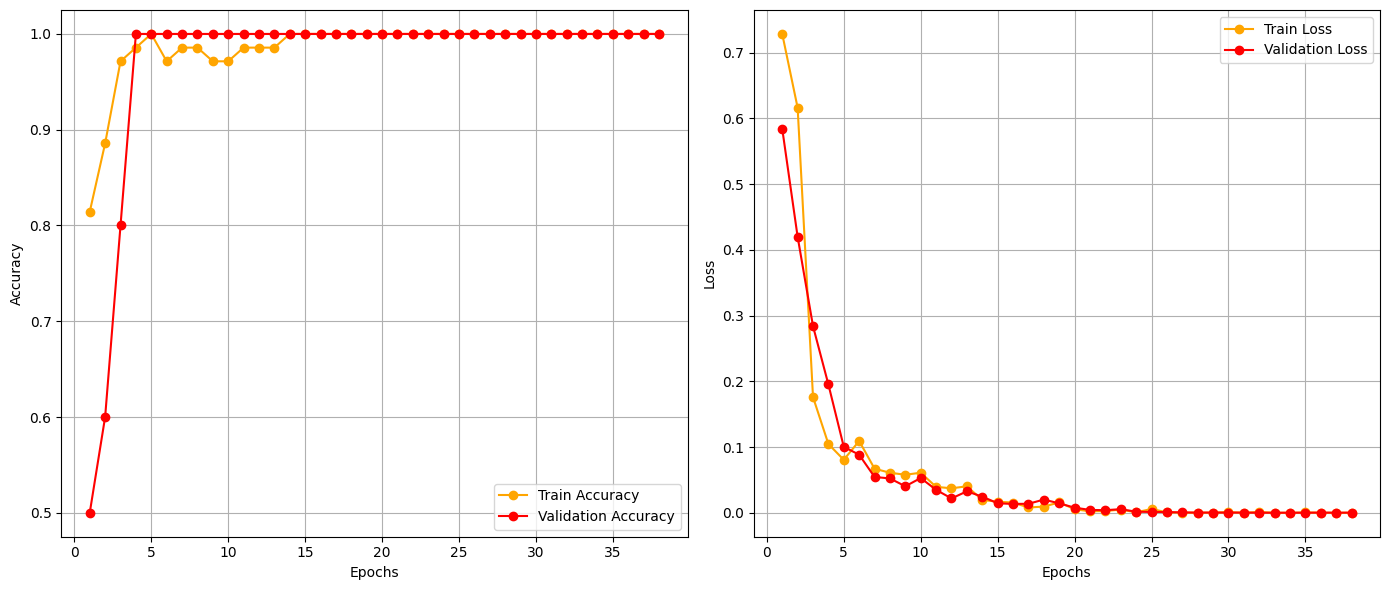

In [28]:
# 로그 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/practice/log/QAT_log.csv')

epochs = df['epoch']
train_acc = df['train_acc']
val_acc = df['val_acc']
train_loss = df['train_loss']
val_loss = df['val_loss']

# 정확도 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(epochs, train_acc, label='Train Accuracy', marker='o', color='orange')
axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# 손실 그래프
axes[1].plot(epochs, train_loss, label='Train Loss', marker='o', color='orange')
axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# **양자화 모델 추론**

In [29]:
# 양자화 모델 로드
int_model = copy.deepcopy(ori_model)
int_model.to(cpu_device)
int_model = torch.ao.quantization.convert(int_model.eval(), inplace=False)
int_model.load_state_dict(torch.load(int8_path))
int_model.eval()


# 양자화된 모델 테스트
total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(cpu_device)
        labels = labels.to(cpu_device)

        outputs = int_model(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

# 테스트 결과 출력
print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

# 양자화 모델 크기 출력
print_model_size(int_model)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
<ipython-input-29-645ca30a0f8e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Test Metrics: Loss=0.0654, Acc=0.9500, Precision=0.9545, Recall=0.9500, F1=0.9499
9.19 MB
